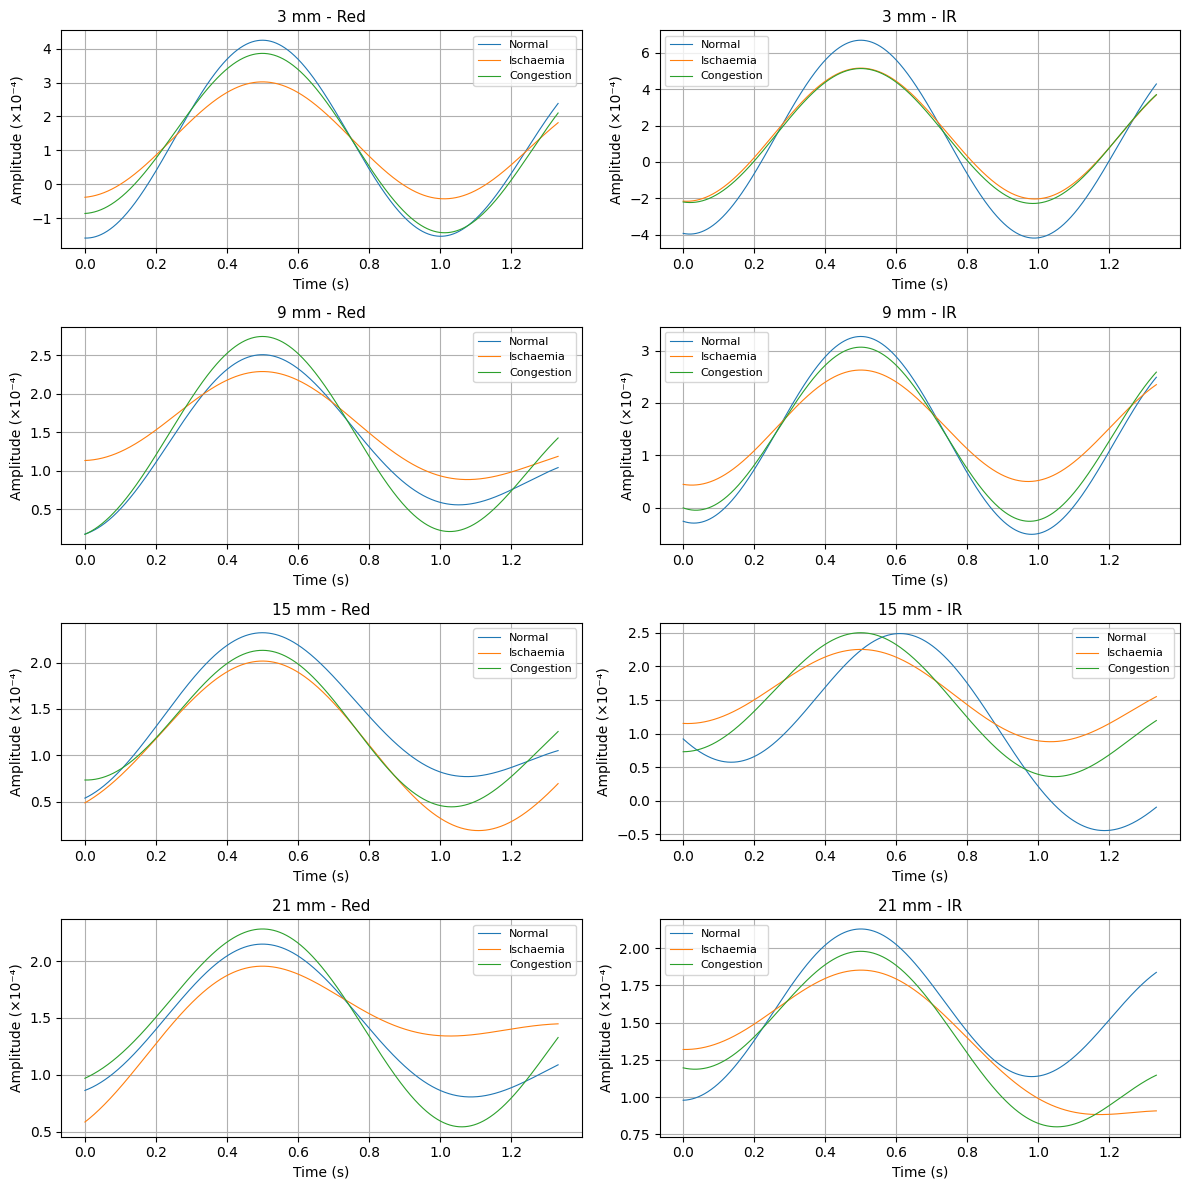

In [ ]:
#PPG波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 表示時間 [秒]
start_search = 3      # 検索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=1.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ch_label) in enumerate(channels.items()):
        ax = axes[i_depth, j_ch]

        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # --- AC/DC正規化 ---
            dc = butter_lowpass_filter(sig, fs, cutoff=0.5)
            sig_norm = (sig - dc) / (dc + 1e-8)

            # --- 強スムージング ---
            smoothed = butter_lowpass_filter(sig_norm, fs, cutoff=1.0)

            # --- 開始5秒以降の最大値（ピーク）を検出 ---
            start_idx = int(start_search * fs)
            if start_idx >= len(smoothed):
                start_idx = 0
            max_idx = np.argmax(smoothed[start_idx:]) + start_idx

            # --- 表示区間（ピーク中心 → 前にずらす） ---
            view_len = int(view_sec * fs)
            pre_offset = int(view_len * 0.25)  # ピークから0.75秒前に開始
            start_plot = max(max_idx - pre_offset, 0)
            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            # --- 表示は先頭2/3まで ---
            cut_len = int(view_len * 2 / 3)
            seg = smoothed[start_plot:start_plot + cut_len]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg * 1e4, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ch_label}", fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (×10⁻⁴)")
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

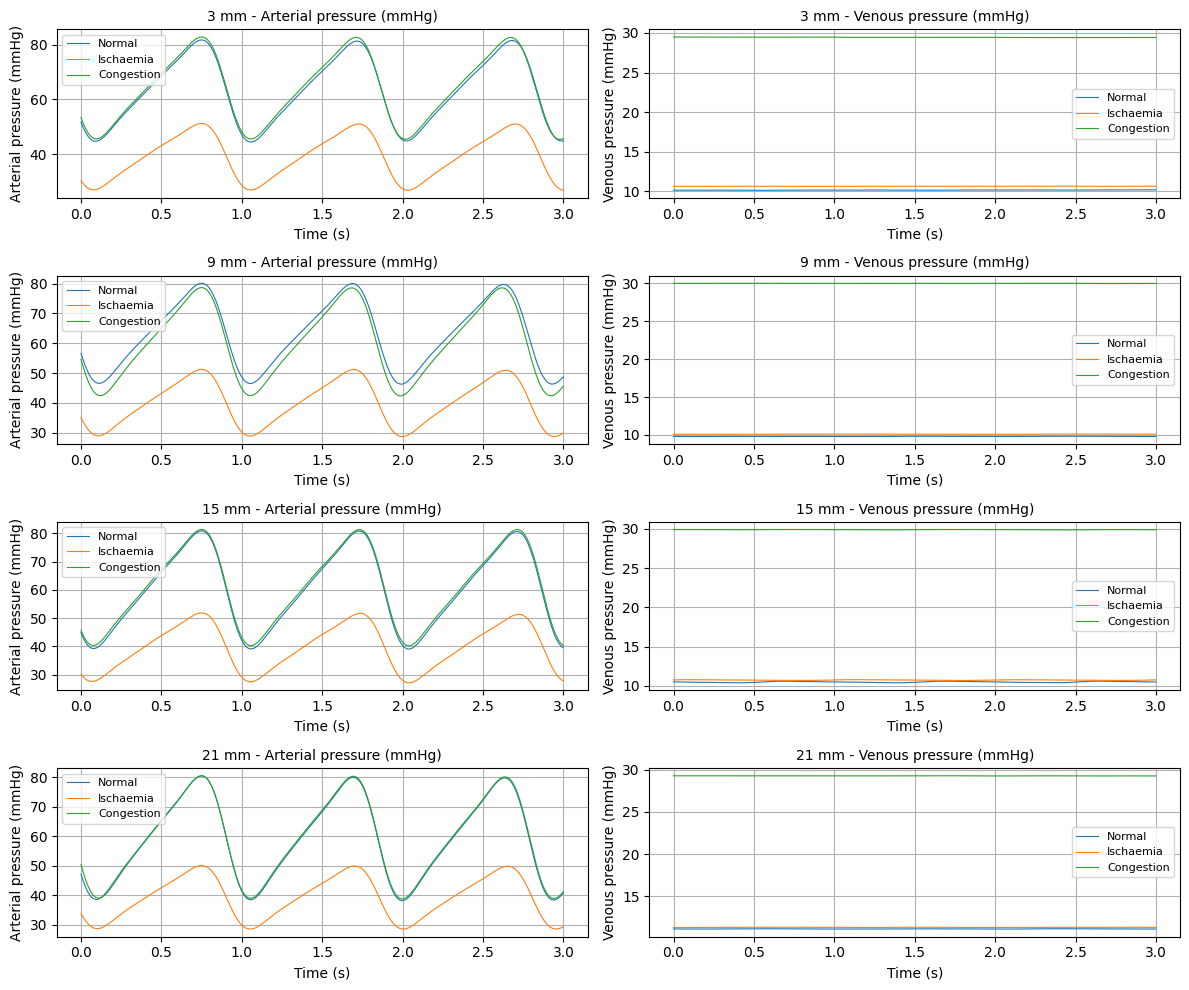

In [ ]:
#圧力波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 3          # 表示時間 [秒]
start_search = 5      # ピーク探索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
pressure_channels = {"p2_mmhg": "Arterial pressure (mmHg)", "p1_mmhg": "Venous pressure (mmHg)"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=3.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ylabel) in enumerate(pressure_channels.items()):
        ax = axes[i_depth, j_ch]
        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # スムージング
            smoothed = butter_lowpass_filter(sig, fs, cutoff=3.0)

            # 表示区間の決定
            view_len = int(view_sec * fs)
            start_idx = int(start_search * fs)

            if col_name == "p2_mmhg":  # 動脈 → ピーク揃え
                max_idx = np.argmax(smoothed[start_idx:]) + start_idx
                pre_offset = int(view_len * 0.25)
                start_plot = max(max_idx - pre_offset, 0)
            else:  # 静脈 → 一律スタート
                start_plot = start_idx

            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            seg = smoothed[start_plot:end_plot]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ylabel}", fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
#AGC処理とcsv生成

import pandas as pd
import numpy as np
from pathlib import Path

# ========= パラメータ =========
fs = 2000             # サンプリング周波数
target_amp = 1.0      # AGC後の目標振幅
gain_limit = (0.1,10) # AGCゲインの上下限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ========= AGC 関数 =========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    """一定区間ごとにAGCをかけて振幅をそろえる"""
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg)==0: continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ========= 全ファイル処理 =========
for depth in depths:
    for i_state, state_name in state_map.items():
        input_file = f"{depth}mm_adjusted_data{i_state}.csv"
        output_file = f"{depth}mm_AGC_data{i_state}.csv"
        
        # ファイル読み込み
        df = pd.read_csv(input_file)
        if not {"ppgA_Red_raw","ppgA_IR_raw"}.issubset(df.columns):
            print(f"[警告] {input_file} に必要な列がありません")
            continue

        # AGC適用
        df["ppgA_Red_AGC"] = apply_agc(df["ppgA_Red_raw"].values, fs, 1, target_amp, gain_limit)
        df["ppgA_IR_AGC"]  = apply_agc(df["ppgA_IR_raw"].values,  fs, 1, target_amp, gain_limit)

        # 保存
        df.to_csv(output_file, index=False)
        print(f"[保存完了] {output_file}")


[保存完了] 3mm_AGC_data1.csv
[保存完了] 3mm_AGC_data2.csv
[保存完了] 3mm_AGC_data3.csv
[保存完了] 9mm_AGC_data1.csv
[保存完了] 9mm_AGC_data2.csv
[保存完了] 9mm_AGC_data3.csv
[保存完了] 15mm_AGC_data1.csv
[保存完了] 15mm_AGC_data2.csv
[保存完了] 15mm_AGC_data3.csv
[保存完了] 21mm_AGC_data1.csv
[保存完了] 21mm_AGC_data2.csv
[保存完了] 21mm_AGC_data3.csv


In [8]:
#SQI計算とcsv生成

import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import savgol_filter, correlate
from scipy.fft import rfft, rfftfreq

# ===== パラメータ =====
fs = 2000              # サンプリング周波数 [Hz]
target_amp = 1.0       # AGC後の目標振幅
window_sec = 8         # SQI評価窓の長さ [秒]
gain_limit = (0.1, 10) # AGCゲインの制限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ======== AGC 関数 ========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg) == 0:
            continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ======== SQI 関数 ========
def compute_sqi(segment, fs):
    if len(segment) < fs:
        return np.nan
    # --- 1. 振幅対雑音比 ---
    amp = segment.max() - segment.min()
    noise = np.std(segment)
    snr = amp / (noise + 1e-8)
    snr_norm = min(snr/10, 1)

    # --- 2. 自己相関 (周期性) ---
    corr = correlate(segment - np.mean(segment), segment - np.mean(segment), mode='full')
    corr = corr[len(corr)//2:]
    corr = corr / (np.max(corr)+1e-8)
    lag_min = int(0.5*fs)
    lag_max = int(1.5*fs)
    if lag_max >= len(corr):
        lag_max = len(corr)-1
    ac_peak = np.max(corr[lag_min:lag_max]) if lag_max>lag_min else 0
    ac_norm = np.clip(ac_peak, 0, 1)

    # --- 3. 周波数ドミナンス ---
    freqs = rfftfreq(len(segment), 1/fs)
    fft_vals = np.abs(rfft(segment))
    mask = (freqs>0.5) & (freqs<3)
    if not np.any(mask):
        return np.nan
    band_power = fft_vals[mask]
    peak = np.max(band_power)
    total = np.sum(band_power)
    dom = peak / (total+1e-8)
    dom_norm = np.clip(dom*5, 0, 1)

    # 総合SQI
    return np.mean([snr_norm, ac_norm, dom_norm])

# ===== SQI計算 =====
records = []

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv")
        if not file.exists():
            print(f"[警告] {file} が存在しません")
            continue

        df = pd.read_csv(file)

        for ch in ["ppgA_Red_AGC", "ppgA_IR_AGC"]:
            sig = savgol_filter(df[ch].values, 51, 3)

            # window_sec ごとに SQI 計算
            step = int(window_sec * fs)
            sqis = []
            for start in range(0, len(sig)-step, step):
                seg = sig[start:start+step]
                sqi_val = compute_sqi(seg, fs)
                sqis.append(sqi_val)

            mean_sqi = np.nanmean(sqis)
            std_sqi = np.nanstd(sqis)
            valid_ratio = np.mean(~np.isnan(sqis))

            records.append({
                "Depth": depth,
                "Condition": state_name,
                "Channel": "Red" if "Red" in ch else "IR",
                "SQI_mean": mean_sqi,
                "SQI_std": std_sqi,
                "Valid_ratio": valid_ratio,
                "n_windows": len(sqis)
            })

# ===== 結果を保存 =====
df_sqi = pd.DataFrame(records)
df_sqi.to_csv("SQI_summary.csv", index=False)
print("✅ SQI_summary.csv を出力しました")
print(df_sqi.round(3))

✅ SQI_summary.csv を出力しました
    Depth   Condition Channel  SQI_mean  SQI_std  Valid_ratio  n_windows
0       3      Normal     Red     0.751    0.001          1.0          3
1       3      Normal      IR     0.735    0.002          1.0          3
2       3   Ischaemia     Red     0.752    0.002          1.0          3
3       3   Ischaemia      IR     0.736    0.001          1.0          3
4       3  Congestion     Red     0.749    0.003          1.0          3
5       3  Congestion      IR     0.738    0.000          1.0          3
6       9      Normal     Red     0.639    0.016          1.0          3
7       9      Normal      IR     0.743    0.000          1.0          3
8       9   Ischaemia     Red     0.666    0.023          1.0          3
9       9   Ischaemia      IR     0.748    0.002          1.0          3
10      9  Congestion     Red     0.701    0.030          1.0          3
11      9  Congestion      IR     0.741    0.001          1.0          3
12     15      Normal    

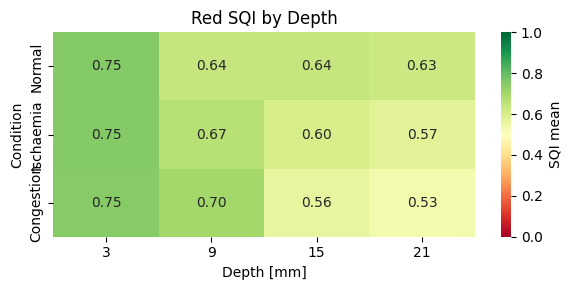

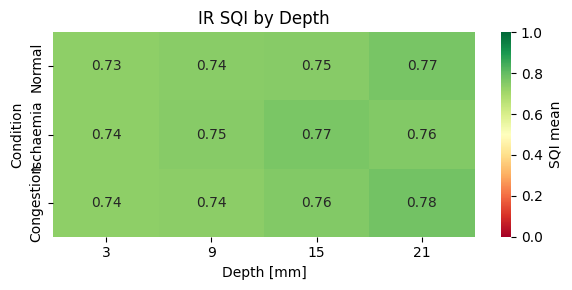

In [9]:
#SQIヒートマップの描画

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== SQI 集計結果の読み込み =====
df_sqi = pd.read_csv("SQI_summary.csv")

# ===== Red と IR に分ける =====
df_red = df_sqi[df_sqi["Channel"] == "Red"]
df_ir  = df_sqi[df_sqi["Channel"] == "IR"]

# ===== Pivotしてヒートマップ用の表を作成 =====
red_pivot = df_red.pivot(index="Condition", columns="Depth", values="SQI_mean")
ir_pivot  = df_ir.pivot(index="Condition", columns="Depth", values="SQI_mean")

# Condition の表示順を統一
order = ["Normal", "Ischaemia", "Congestion"]
red_pivot = red_pivot.reindex(order)
ir_pivot  = ir_pivot.reindex(order)

# ===== ヒートマップ描画 =====
def plot_sqi_heatmap(data, title):
    plt.figure(figsize=(6,3))
    sns.heatmap(
        data,
        annot=True, fmt=".2f",
        cmap="RdYlGn", center=0.5,  # 0.5 を基準色に
        vmin=0, vmax=1,             # SQI の範囲を 0〜1 に固定
        cbar_kws={"label": "SQI mean"}
    )
    plt.title(title)
    plt.xlabel("Depth [mm]")
    plt.ylabel("Condition")
    plt.tight_layout()
    plt.show()

plot_sqi_heatmap(red_pivot, "Red SQI by Depth")
plot_sqi_heatmap(ir_pivot,  "IR SQI by Depth")

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

# ===== パラメータ =====
depths = [3, 9, 15, 21]
group_names = ["Normal", "Ischaemia", "Congestion"]

# ===== 結果格納用リスト =====
results = []

# ===== 各深さについてKruskal-Wallis検定 =====
for depth in depths:
    # ファイル読み込み（AGC済みデータを使用）
    files = [
        (f"{depth}mm_AGC_data1.csv", "Normal"),
        (f"{depth}mm_AGC_data2.csv", "Ischaemia"),
        (f"{depth}mm_AGC_data3.csv", "Congestion"),
    ]

    red_groups = []
    ir_groups = []
    
    for file, _ in files:
        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].values
        ir = df["ppgA_IR_AGC"].values

        # 窓ごとの振幅（最大-最小）
        fs = 2000
        window_sec = 1
        step = fs * window_sec
        n_win = len(red) // step

        red_amp = []
        ir_amp = []
        for w in range(n_win):
            s = w * step
            e = s + step
            rseg = red[s:e]
            iseg = ir[s:e]
            if len(rseg) < 2 or len(iseg) < 2:
                continue
            red_amp.append(rseg.max() - rseg.min())
            ir_amp.append(iseg.max() - iseg.min())

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # 正規化（IR Normalの平均 = 0.5に）
    normal_ir_mean = np.mean(ir_groups[0])
    scale_factor = 0.5 / normal_ir_mean
    red_groups_scaled = [[v * scale_factor for v in g] for g in red_groups]
    ir_groups_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

    # Kruskal-Wallis検定
    stat_red, p_red = kruskal(*red_groups_scaled)
    stat_ir,  p_ir  = kruskal(*ir_groups_scaled)

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "Red",
        "Chi-Squared": stat_red,
        "df": len(red_groups_scaled)-1,
        "p-Value": p_red
    })

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "IR",
        "Chi-Squared": stat_ir,
        "df": len(ir_groups_scaled)-1,
        "p-Value": p_ir
    })

# ===== 結果の保存 =====
df_result = pd.DataFrame(results)
df_result.to_csv("KW_result.csv", index=False)

# ===== 結果の表示 =====
print("✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):")
print(df_result.round(4))


✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):
  Depth Channel  Chi-Squared  df  p-Value
0   3mm     Red      59.8612   2   0.0000
1   3mm      IR      71.5815   2   0.0000
2   9mm     Red      35.9352   2   0.0000
3   9mm      IR      61.9042   2   0.0000
4  15mm     Red       9.1090   2   0.0105
5  15mm      IR      65.0099   2   0.0000
6  21mm     Red      23.7721   2   0.0000
7  21mm      IR      53.1963   2   0.0000


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm
import os

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
group_names = list(states.values())

# ===== Dunn test関数 =====
def dunn_test(groups, group_labels):
    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i, g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)
    ties_correction = 1 - (np.sum(np.bincount(ranks.astype(int))[1:]**3 - np.bincount(ranks.astype(int))[1:]) / (n**3 - n))
    if ties_correction <= 0: ties_correction = 1

    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id==i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i]/n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt((n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction)
            Z = diff / SE
            p = 2 * (1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{group_labels[i]} vs {group_labels[j]}",
                "Z": Z,
                "p_Unadj": p
            })

    df = pd.DataFrame(results)
    df["p_Adj"] = np.minimum(df["p_Unadj"] * len(df), 1.0)
    return df

# ===== 結果格納用 =====
all_results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC_{data_key}.csv"
        if not os.path.exists(file):
            print(f"⚠️ File not found: {file}")
            continue

        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].dropna().values
        ir  = df["ppgA_IR_AGC"].dropna().values

        step = int(fs * window_sec)
        red_amp = [(red[i:i+step].max() - red[i:i+step].min())
                   for i in range(0, len(red) - step, step)]
        ir_amp = [(ir[i:i+step].max() - ir[i:i+step].min())
                  for i in range(0, len(ir) - step, step)]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ========== Dunn検定 (Red) ==========
    df_dunn_red = dunn_test(red_groups, group_names)
    df_dunn_red.insert(1, "Channel", "Red")
    df_dunn_red.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_red)

    # ========== Dunn検定 (IR) ==========
    df_dunn_ir = dunn_test(ir_groups, group_names)
    df_dunn_ir.insert(1, "Channel", "IR")
    df_dunn_ir.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_ir)

# ===== 結果統合・保存 =====
df_all = pd.concat(all_results, ignore_index=True)
df_all = df_all[["Comparison", "Channel", "Depth", "Z", "p_Unadj", "p_Adj"]]
df_all = df_all.rename(columns={
    "p_Unadj": "p (Unadjusted)",
    "p_Adj": "p (Adjusted)"
})

# 表示
print("\n=== Dunn post-hoc test results across all depths ===")
print(df_all.round(4))

# 保存
df_all.to_csv("dunn_posthoc_all_depths.csv", index=False)
print("\n✅ Dunn test results saved to 'dunn_posthoc_all_depths.csv'")



=== Dunn post-hoc test results across all depths ===
                 Comparison Channel Depth       Z  p (Unadjusted)  \
0       Normal vs Ischaemia     Red   3mm  7.0320          0.0000   
1      Normal vs Congestion     Red   3mm  0.7215          0.4706   
2   Ischaemia vs Congestion     Red   3mm -6.3105          0.0000   
3       Normal vs Ischaemia      IR   3mm  8.4206          0.0000   
4      Normal vs Congestion      IR   3mm  4.9219          0.0000   
5   Ischaemia vs Congestion      IR   3mm -3.4987          0.0005   
6       Normal vs Ischaemia     Red   9mm  3.9725          0.0001   
7      Normal vs Congestion     Red   9mm -1.8242          0.0681   
8   Ischaemia vs Congestion     Red   9mm -5.7629          0.0000   
9       Normal vs Ischaemia      IR   9mm  7.4853          0.0000   
10     Normal vs Congestion      IR   9mm  1.7135          0.0866   
11  Ischaemia vs Congestion      IR   9mm -5.8214          0.0000   
12      Normal vs Ischaemia     Red  15mm  1.2107

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolo

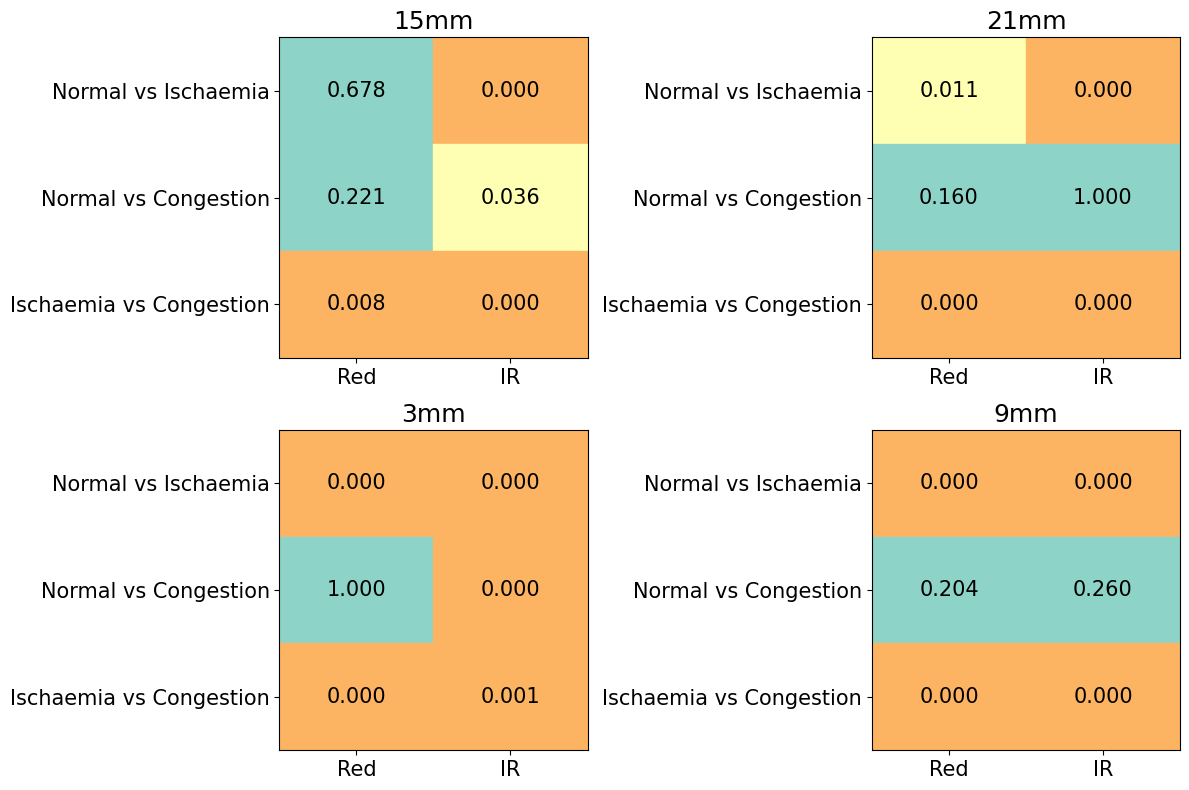

In [12]:
# 再度必要なパッケージをインポートしてコードを実行

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ファイル読み込み
df = pd.read_csv("dunn_posthoc_all_depths.csv")

# 深さごとのデータに分割
depths = df["Depth"].unique()
depths.sort()

# 比較軸とチャネルの順序を定義
comparisons = ["Normal vs Ischaemia", "Normal vs Congestion", "Ischaemia vs Congestion"]
channels = ["Red", "IR"]

# 色のマップ関数：p値に応じて色を設定
def get_color(p):
    if p < 0.01:
        return "#fdb462"  # 優しい青緑
    elif p < 0.05:
        return "#ffffb3"  # 優しい黄色
    else:
        return "#8dd3c7"  # 優しいオレンジ

# プロット準備
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, depth in enumerate(depths):
    ax = axes[idx]
    sub_df = df[df["Depth"] == depth]

    # 描画用マトリクス作成
    heatmap_data = pd.DataFrame(index=comparisons, columns=channels)

    for _, row in sub_df.iterrows():
        heatmap_data.loc[row["Comparison"], row["Channel"]] = row["p (Adjusted)"]

    # 数値のp値を float で保存し、色塗り用に用いる
    p_values = heatmap_data.astype(float)

    # 手動で heatmap 描画（p値に応じた背景色、文字重ね）
    for i, comp in enumerate(comparisons):
        for j, ch in enumerate(channels):
            p_val = p_values.loc[comp, ch]
            color = get_color(p_val)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
            ax.text(j + 0.5, i + 0.5, f"{p_val:.3f}", ha='center', va='center', fontsize=15)

    # 軸設定
    ax.set_xticks(np.arange(len(channels)) + 0.5)
    ax.set_yticks(np.arange(len(comparisons)) + 0.5)
    ax.set_xticklabels(channels, fontsize=15)
    ax.set_yticklabels(comparisons, fontsize=15)
    ax.set_xlim(0, len(channels))
    ax.set_ylim(0, len(comparisons))
    ax.set_title(f"{depth}", fontsize=18)
    ax.invert_yaxis()
    ax.set_aspect('auto')  # 自動で長方形化
    ax.grid(False)

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score, roc_curve

# ========= 基本設定 =========
fs = 2000  # Hz
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}
channels = {"ppgA_Red_AGC": "Red", "ppgA_IR_AGC": "IR"} 

# bpmテーブル（ユーザー提供値）
bpm_table = {
    3:  {"Normal": 60.8, "Ischaemia": 60.8, "Congestion": 62.3},
    9:  {"Normal": 62.7, "Ischaemia": 64.7, "Congestion": 64.3},
    15: {"Normal": 60.4, "Ischaemia": 60.8, "Congestion": 60.8},
    21: {"Normal": 65.1, "Ischaemia": 63.2, "Congestion": 63.2},
}

# ========= 拍動特徴抽出関数 (変更なし) =========
def extract_pulse_features(signal, fs, prom=0.001, dist=0.3):
    peaks, _ = find_peaks(signal, prominence=prom, distance=int(fs * dist))
    feats = []
    if len(peaks) < 2:
        return []

    for p in peaks:
        left = max(0, p - int(0.5 * fs))
        right = min(len(signal), p + int(0.5 * fs))
        seg = signal[left:right]
        
        if len(seg) < 5:
            continue
            
        peak_idx_in_seg = np.argmax(seg)
        trough_idx_in_seg = np.argmin(seg[:peak_idx_in_seg+1])
        next_trough_idx_in_seg = peak_idx_in_seg + np.argmin(seg[peak_idx_in_seg:])
        
        if trough_idx_in_seg < peak_idx_in_seg < next_trough_idx_in_seg:
            rise = (peak_idx_in_seg - trough_idx_in_seg) / fs
            fall = (next_trough_idx_in_seg - peak_idx_in_seg) / fs
            baseline = seg[trough_idx_in_seg]
            peak_val = seg[peak_idx_in_seg]
            
            half = baseline + 0.5 * (peak_val - baseline)
            segment_for_pw = seg[trough_idx_in_seg:next_trough_idx_in_seg+1] 
            above = np.where(segment_for_pw >= half)[0]
            pw = (above[-1] - above[0]) / fs if len(above) > 1 else np.nan
            
            amp = peak_val - baseline
            
            feats.append((rise, fall, pw, amp))
    return feats

# ========= データ読み込み & 特徴抽出 =========
records = []
pulse_id_counter = 0

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv") 
        try:
            df = pd.read_csv(file)
        except FileNotFoundError:
            # ファイルが見つからない場合は警告
            print(f"Warning: File not found: {file}. Skipping.")
            continue
            
        bpm = bpm_table[depth][state_name]
        window_sec = 60.0 / bpm
        step = int(round(fs * window_sec))

        for col, ch_label in channels.items():
            sig = df[col].values
            
            # (1) 1拍ごとのAmplitude計算（最大-最小）
            n_win = len(sig) // step
            for w in range(n_win):
                s, e = w * step, (w + 1) * step
                seg = sig[s:e]
                if len(seg) < 5:
                    continue
                amp = seg.max() - seg.min()
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter, 
                    "RiseTime": np.nan, "FallTime": np.nan, 
                    "PulseWidth": np.nan, "Amplitude": amp 
                })
                
            # (2) find_peaksで特徴抽出
            feats = extract_pulse_features(sig, fs)
            for r, f, pw, amp in feats:
                records.append({
                    "Depth": depth, "State": state_name, "Channel": ch_label,
                    "Pulse_ID": pulse_id_counter, 
                    "RiseTime": r, "FallTime": f, 
                    "PulseWidth": pw, "Amplitude": amp 
                })
            
            pulse_id_counter += 1

df_feat = pd.DataFrame(records)

if df_feat.empty:
    print("Error: No data was loaded. Please check your CSV file paths and names (using '*AGC*' files).")
    exit()

# ========= 複合指標を追加 =========
df_feat["RiseFall_ratio"] = df_feat["RiseTime"] / (df_feat["FallTime"] + 1e-6)
df_feat["Pulse_Area"] = df_feat["PulseWidth"] * df_feat["Amplitude"] 

# ========= 正規化 =========
def normalize_channel(df, ch):
    """チャンネルごとにNormal 3mmの平均Amplitudeで正規化する"""
    base_amp = df.query("Channel==@ch and Depth==3 and State=='Normal'")["Amplitude"].mean()
    if pd.isna(base_amp) or base_amp == 0:
        print(f"Error: Baseline amplitude for Normal 3mm {ch} is zero or not found.")
        df.loc[df.Channel == ch, "Amp_norm"] = np.nan
        return False
    df.loc[df.Channel == ch, "Amp_norm"] = df.loc[df.Channel == ch, "Amplitude"] / base_amp
    return True

# Amplitude の正規化を実行
normalize_channel(df_feat, "Red")
normalize_channel(df_feat, "IR")

df_feat["Pulse_Area_norm"] = df_feat["PulseWidth"] * df_feat["Amp_norm"]

# ========= Red/IR比の計算のためのデータ前処理 =========

amp_data = df_feat.dropna(subset=['Amplitude', 'Amp_norm']).copy()

df_red = amp_data[amp_data.Channel == "Red"].rename(
    columns={"Amplitude": "Amplitude_Red", "Amp_norm": "Amp_norm_Red"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_Red', 'Amp_norm_Red']]

df_ir = amp_data[amp_data.Channel == "IR"].rename(
    columns={"Amplitude": "Amplitude_IR", "Amp_norm": "Amp_norm_IR"}
)[['Depth', 'State', 'Pulse_ID', 'Amplitude_IR', 'Amp_norm_IR']]

# Depth, State, Pulse_ID をキーとして結合（対応する脈波ペアのみ残す）
df_ratio = pd.merge(
    df_red,
    df_ir,
    on=['Depth', 'State', 'Pulse_ID'],
    how='inner' 
)

# 2. Red/IR比を計算
df_ratio["Red_IR_amp_ratio"] = df_ratio["Amplitude_Red"] / (df_ratio["Amplitude_IR"] + 1e-6)
df_ratio["Red_IR_amp_norm_ratio"] = df_ratio["Amp_norm_Red"] / (df_ratio["Amp_norm_IR"] + 1e-6)


# ========= ROC AUC計算 (ブートストラップ付) =========
pairs = [("Normal", "Ischaemia"), ("Normal", "Congestion"), ("Ischaemia", "Congestion")]
features_to_eval = [
    "Amp_norm", 
    "RiseTime", "FallTime", "PulseWidth", 
    "RiseFall_ratio", 
    "Pulse_Area", 
]
ratio_features_to_eval = ["Red_IR_amp_ratio", "Red_IR_amp_norm_ratio"] 

def bootstrap_auc_ci(y_true, y_score, n_bootstrap=50, alpha=0.05):
    rng = np.random.default_rng(42)
    aucs = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, n)
        if len(np.unique(y_true[idx])) < 2 or np.all(y_score[idx] == y_score[idx][0]):
            continue
        try:
            aucs.append(roc_auc_score(y_true[idx], y_score[idx]))
        except ValueError:
            continue
            
    if len(aucs) == 0:
        return np.nan, np.nan, np.nan
    return np.mean(aucs), np.percentile(aucs, 2.5), np.percentile(aucs, 97.5)

rows = []

# --- 1. チャンネルごとの特徴量の処理 ---
for ch in ["Red", "IR"]:
    for depth in depths:
        sub = df_feat[(df_feat.Channel == ch) & (df_feat.Depth == depth)]
        if sub.empty:
            continue
        
        for feature in features_to_eval:
            for cls1, cls2 in pairs:
                d = sub[sub.State.isin([cls1, cls2])]
                if d.empty:
                    continue

                # --- NaN 除外 ---
                y_true = (d["State"] == cls1).astype(int).values
                y_score = d[feature].values
                mask = ~np.isnan(y_score)
                y_true = y_true[mask]
                y_score = y_score[mask]
                # サンプルサイズとクラス変動のチェック
                if len(y_true) < 10 or len(np.unique(y_true)) < 2 or np.all(y_score == y_score[0]):
                    continue

                auc_point = roc_auc_score(y_true, y_score)
                auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)
                
                # 最適な閾値の計算
                fpr, tpr, thr = roc_curve(y_true, y_score)
                youden = tpr - fpr
                idx = np.argmax(youden)
                cutoff = thr[idx]
                sens = tpr[idx]
                spec = 1 - fpr[idx]

                rows.append({
                    "Channel": ch,
                    "Depth": depth,
                    "Feature": feature,
                    "Pair": f"{cls1} vs {cls2}",
                    "AUC": auc_point,
                    "AUC_bootstrap_mean": auc_bs,
                    "CI_lower": ci_lo,
                    "CI_upper": ci_hi,
                    "Cutoff": cutoff,
                    "Sensitivity": sens,
                    "Specificity": spec,
                    "n_samples": len(y_true)
                })

# --- 2. Red/IR比の特徴量の処理 ---
for depth in depths:
    sub_ratio = df_ratio[df_ratio.Depth == depth]
    if sub_ratio.empty:
        # 比率データが空の場合、警告を出力
        print(f"Warning: No valid Red/IR ratio data found for Depth {depth}mm.")
        continue
    
    for feature in ratio_features_to_eval:
        for cls1, cls2 in pairs:
            d = sub_ratio[sub_ratio.State.isin([cls1, cls2])]
            if d.empty:
                continue

            # --- NaN 除外 ---
            y_true = (d["State"] == cls1).astype(int).values
            y_score = d[feature].values
            mask = ~np.isnan(y_score)
            y_true = y_true[mask]
            y_score = y_score[mask]
            # サンプルサイズとクラス変動のチェック
            if len(y_true) < 10 or len(np.unique(y_true)) < 2 or np.all(y_score == y_score[0]):
                continue

            auc_point = roc_auc_score(y_true, y_score)
            auc_bs, ci_lo, ci_hi = bootstrap_auc_ci(y_true, y_score)

            fpr, tpr, thr = roc_curve(y_true, y_score)
            youden = tpr - fpr
            idx = np.argmax(youden)
            cutoff = thr[idx]
            sens = tpr[idx]
            spec = 1 - fpr[idx]

            rows.append({
                "Channel": "Red/IR_Ratio", 
                "Depth": depth,
                "Feature": feature,
                "Pair": f"{cls1} vs {cls2}",
                "AUC": auc_point,
                "AUC_bootstrap_mean": auc_bs,
                "CI_lower": ci_lo,
                "CI_upper": ci_hi,
                "Cutoff": cutoff,
                "Sensitivity": sens,
                "Specificity": spec,
                "n_samples": len(y_true)
            })


df_auc_feat = pd.DataFrame(rows)
df_auc_feat.to_csv("AUC_all_features_95CI_final_RedIRRatio.csv", index=False)
print("Saved AUC_all_features_95CI_final_RedIRRatio.csv")

# 比率の結果が確認しやすいように、Channel 'Red/IR_Ratio' の行のみを表示します。
df_ratio_results = df_auc_feat[df_auc_feat['Channel'] == 'Red/IR_Ratio']
if not df_ratio_results.empty:
    print("\n--- Red/IR Ratio Results Confirmation ---")
    print(df_ratio_results.round(3))
else:
    print("\n--- Red/IR Ratio Results Confirmation ---")
    print("Warning: No Red/IR Ratio results were generated. This indicates insufficient corresponding data pairs (Red and IR) in the source files to meet the minimum sample size requirement (n=10) for AUC calculation.")

Saved AUC_all_features_95CI_final_RedIRRatio.csv

--- Red/IR Ratio Results Confirmation ---


/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_28293/3335437166.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


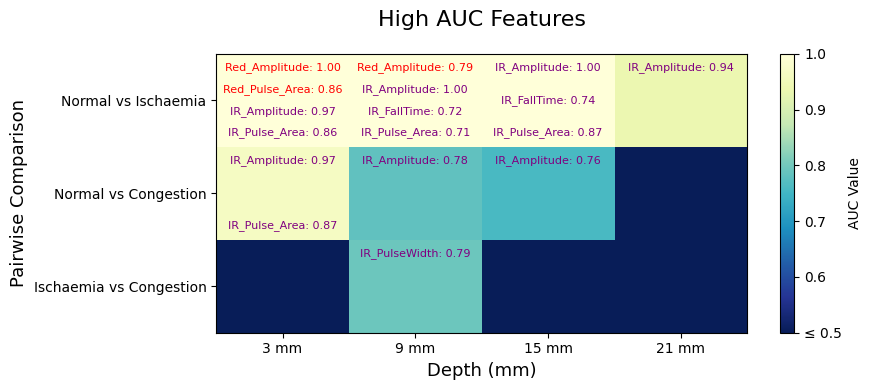

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========

# 最終的に生成されたAUCサマリーファイル名を指定（必要に応じて変更してください）
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio.csv"
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please run the previous code block to generate the CSV.")
    exit()

# NaN値を含む行を削除し、AUC値が0.7未満のものは無視する
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.7].copy() # プロット対象（AUC>0.7）のみ

# ========= 2. 特徴量の整形と色の定義 =========

# 2.1. 特徴名のマッピングと結合
def format_feature_name(row):
    feature = row['Feature']
    channel = row['Channel']
    
    # Amp_normをAmplitudeに改名
    if feature == 'Amp_norm':
        feature = 'Amplitude'
        
    # Pulse_Area_normはPulse_Areaと同一とみなし削除（Noneを返すことでフィルタリング）
    if feature == 'Pulse_Area_norm':
        return None
        
    # ChannelとFeatureを結合 
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        # Ratioの場合はFeature名をそのまま使用（例: Red_IR_amp_norm_ratio）
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

# 2.2. 色の定義
def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

# 2.3. ヒートマップ描画用データフレームの準備
# 縦軸のペアの順序を定義
pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion',
    'Ischaemia vs Congestion'
]
# 横軸のDepthの順序を定義
depth_order = sorted(df_filtered_plot['Depth'].unique())

# グリッドの各セルに表示するテキストと背景色の値を準備
text_grid = {} # key: (Pair, Depth), value: [(text, color, auc_value), ...]
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

for index, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']
    
    key = (pair, depth)
    
    # テキスト準備
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)
    
    if key not in text_grid:
        text_grid[key] = []
    text_grid[key].append((text, color, auc_value))
    
    # 背景色の基準（セル内の最大AUC）を更新
    if pair in pair_order and depth in depth_order:
        current_max = heatmap_values.loc[pair, depth]
        if pd.isna(current_max) or auc_value > current_max:
            heatmap_values.loc[pair, depth] = auc_value


# AUCが0.7未満（プロット対象外）のセルは、カラーマップの最小値（0.5）で埋める
MIN_AUC_FOR_CMAP = 0.5 
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP) 

# ========= 3. ヒートマップのプロット =========

fig, ax = plt.subplots(figsize=(9, 4)) # figsizeを少し大きく調整

# 3.1. 背景色 (AUCが高いほど明るい色、青を0.5付近に)
cmap = plt.cm.get_cmap('YlGnBu_r') 
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0) 

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 3.2. 軸の設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order])
ax.set_yticklabels(pair_order)

ax.set_xlabel('Depth (mm)', fontsize=13)
ax.set_ylabel('Pairwise Comparison', fontsize=13)
ax.set_title(f'High AUC Features', fontsize=16, pad=20)

# 3.3. テキストの描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        
        # AUC > 0.7のデータがあるセルのみにテキストを描画
        if key in text_grid and heatmap_values.loc[pair, depth] > 0.7:
            entries = [(t, c) for t, c, a in text_grid[key]] # (text, color) のみを使用
            
            # セル内のテキスト配置を調整
            n_entries = len(entries)
            
            # 垂直方向の中心から上下にずらして配置
            y_offsets = np.linspace(-0.35, 0.35, n_entries)
            
            for k, (text, color) in enumerate(entries):
                ax.text(j, i + y_offsets[k],
                        text, 
                        ha="center", 
                        va="center", 
                        color=color, 
                        fontsize=8, 
                        linespacing=1.2)

# 3.4. カラーバーの追加と修正
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')

# Y軸のラベルを設定
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
# 最小値のラベルをカスタマイズ (AUC <= 0.5)
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'

# Y軸の目盛りラベルを設定（これが正しい方法）
cbar.ax.set_yticklabels(custom_labels) 

# ★ エラーの原因となっていた X軸のラベル設定を削除 ★
# cbar.ax.set_xticklabels(...) # この行を削除

plt.tight_layout()
plt.show()

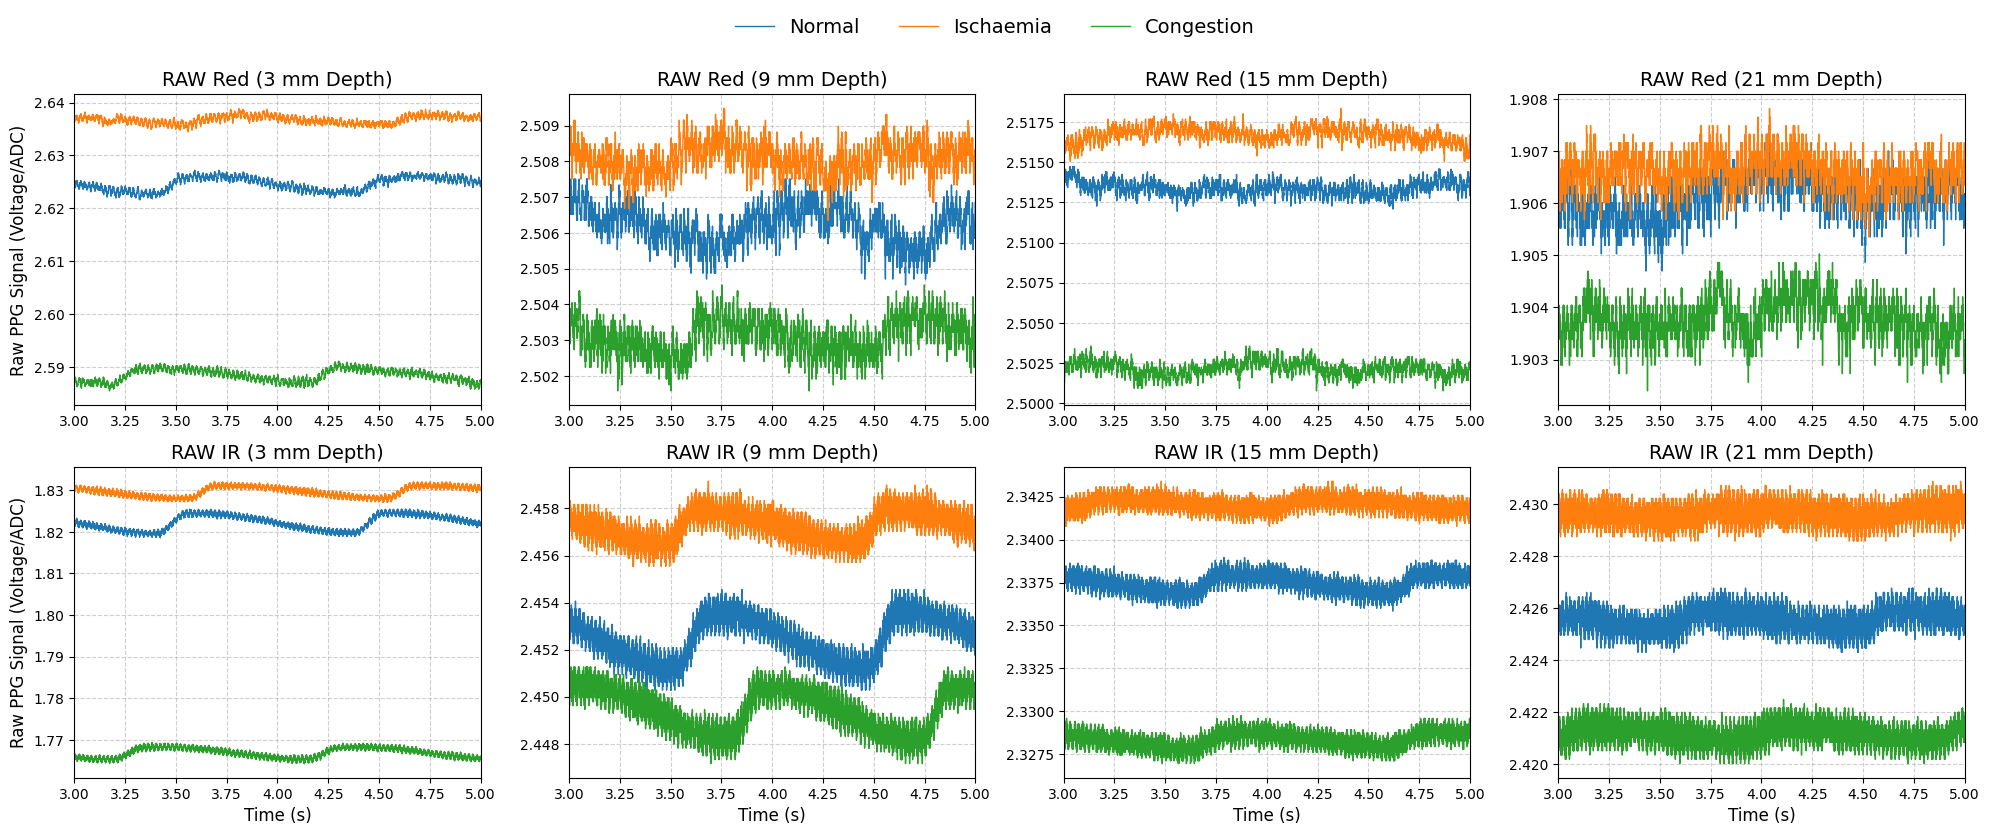

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 表示する時間 [秒]
start_search = 3      # 表示開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

# 表示データの範囲を秒からインデックスに変換
start_index = int(start_search * fs)
end_index = int((start_search + view_sec) * fs)


# ===== プロット実行 =====
# figとaxesを作成 (2行 x 4列: Depth=4, Channel=2, 合計8グラフ)
fig, axes = plt.subplots(len(channels), len(depths), figsize=(20, 8), sharey=False) # sharey=False: グラフごとにY軸スケールを調整

# チャンネルのインデックス (行)
for row_idx, (channel_key, channel_name) in enumerate(channels.items()):
    
    # 深さのインデックス (列)
    for col_idx, depth in enumerate(depths):
        
        ax = axes[row_idx, col_idx]
        
        # 3つの状態のデータを読み込み、重ねてプロット
        for state_key, state_name in state_map.items():
            
            # ファイル名を作成
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            
            try:
                # データの読み込み
                df = pd.read_csv(file_name) 
                
                # 指定されたチャンネルと時間範囲のデータを抽出
                signal = df[channel_key].values[start_index:end_index]
                
                # 時間軸の作成 (秒)
                time_axis = np.arange(len(signal)) / fs + start_search
                
                # プロット (スムージング、正規化、シフトなし)
                ax.plot(time_axis, signal, label=state_name, linewidth=1)
                
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                if state_key == "data1":
                     ax.text(0.5, 0.5, 'Data Missing', transform=ax.transAxes, ha='center', va='center', color='red', fontsize=12)


        # グラフの装飾
        ax.set_title(f"RAW {channel_name} ({depth} mm Depth)", fontsize=14)
        ax.set_xlim(start_search, start_search + view_sec)
        # Y軸の自動調整を許可 (sharey=False)
        ax.grid(axis='both', linestyle='--', alpha=0.6)

        # 軸ラベルの設定 (外側のグラフのみ)
        if row_idx == len(channels) - 1: # 一番下の行
            ax.set_xlabel("Time (s)", fontsize=12)
        if col_idx == 0: # 一番左の列
            ax.set_ylabel(f"Raw PPG Signal (Voltage/ADC)", fontsize=12)

# 凡例の設定
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)

# 全体の調整
plt.tight_layout(rect=[0, 0, 1, 0.98]) # 凡例のためのスペース確保
plt.show()

In [86]:
import pandas as pd
import numpy as np
import os

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 3          # 解析する時間 [秒]
start_search = 3      # 解析開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
# 'raw' データのみをターゲットにする
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}
output_file = "ppg_raw_min_max_summary.csv"

# 表示データの範囲を秒からインデックスに変換
start_index = int(start_search * fs)
end_index = int((start_search + view_sec) * fs)

# 結果を格納するためのDataFrameを初期化
# カラム: Depth (mm), Channel, State, Min_Value, Max_Value
results = []

# ----------------------------------------------------------------------
# ===== データ抽出と結果格納の実行 =====
# ----------------------------------------------------------------------

print(f"Starting data analysis ({start_search}s to {start_search + view_sec}s) and compiling results...")

# チャンネルごとに処理
for channel_key, channel_name in channels.items():
    
    # 深さごとに処理
    for depth in depths:
        
        # 状態ごとに min/max を計算
        for state_key, state_name in state_map.items():
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            
            data_min, data_max = np.nan, np.nan # データが見つからない場合の初期値
            
            try:
                # データの読み込み
                df = pd.read_csv(file_name) 
                
                # 指定されたチャンネルと時間範囲のデータを抽出
                signal = df[channel_key].values[start_index:end_index]
                
                # min, max を計算
                data_min = np.min(signal)
                data_max = np.max(signal)
                
            except FileNotFoundError:
                print(f"  Warning: File not found for {channel_name} @ {depth}mm, {state_name}")
            except KeyError:
                print(f"  Warning: Column '{channel_key}' not found in file for {channel_name} @ {depth}mm, {state_name}.")

            # 結果をリストに追加
            results.append({
                "Depth (mm)": depth,
                "Channel": channel_name,
                "State": state_name,
                "Min_Value": data_min,
                "Max_Value": data_max
            })

# ----------------------------------------------------------------------
# ===== DataFrameに変換し、CSVに出力 =====
# ----------------------------------------------------------------------

results_df = pd.DataFrame(results)

# CSVファイルに保存
results_df.to_csv(output_file, index=False, float_format='%.6e') # 科学記数法で保存
print("\n--- Output Summary ---")
print(f"Successfully compiled {len(results_df)} entries.")
print(f"Results saved to: {os.path.abspath(output_file)}")
print("----------------------")

Starting data analysis (3s to 6s) and compiling results...

--- Output Summary ---
Successfully compiled 24 entries.
Results saved to: /Users/hirokikodama/Documents/GitHub/Phantom-analysis/ppg_raw_min_max_summary.csv
----------------------


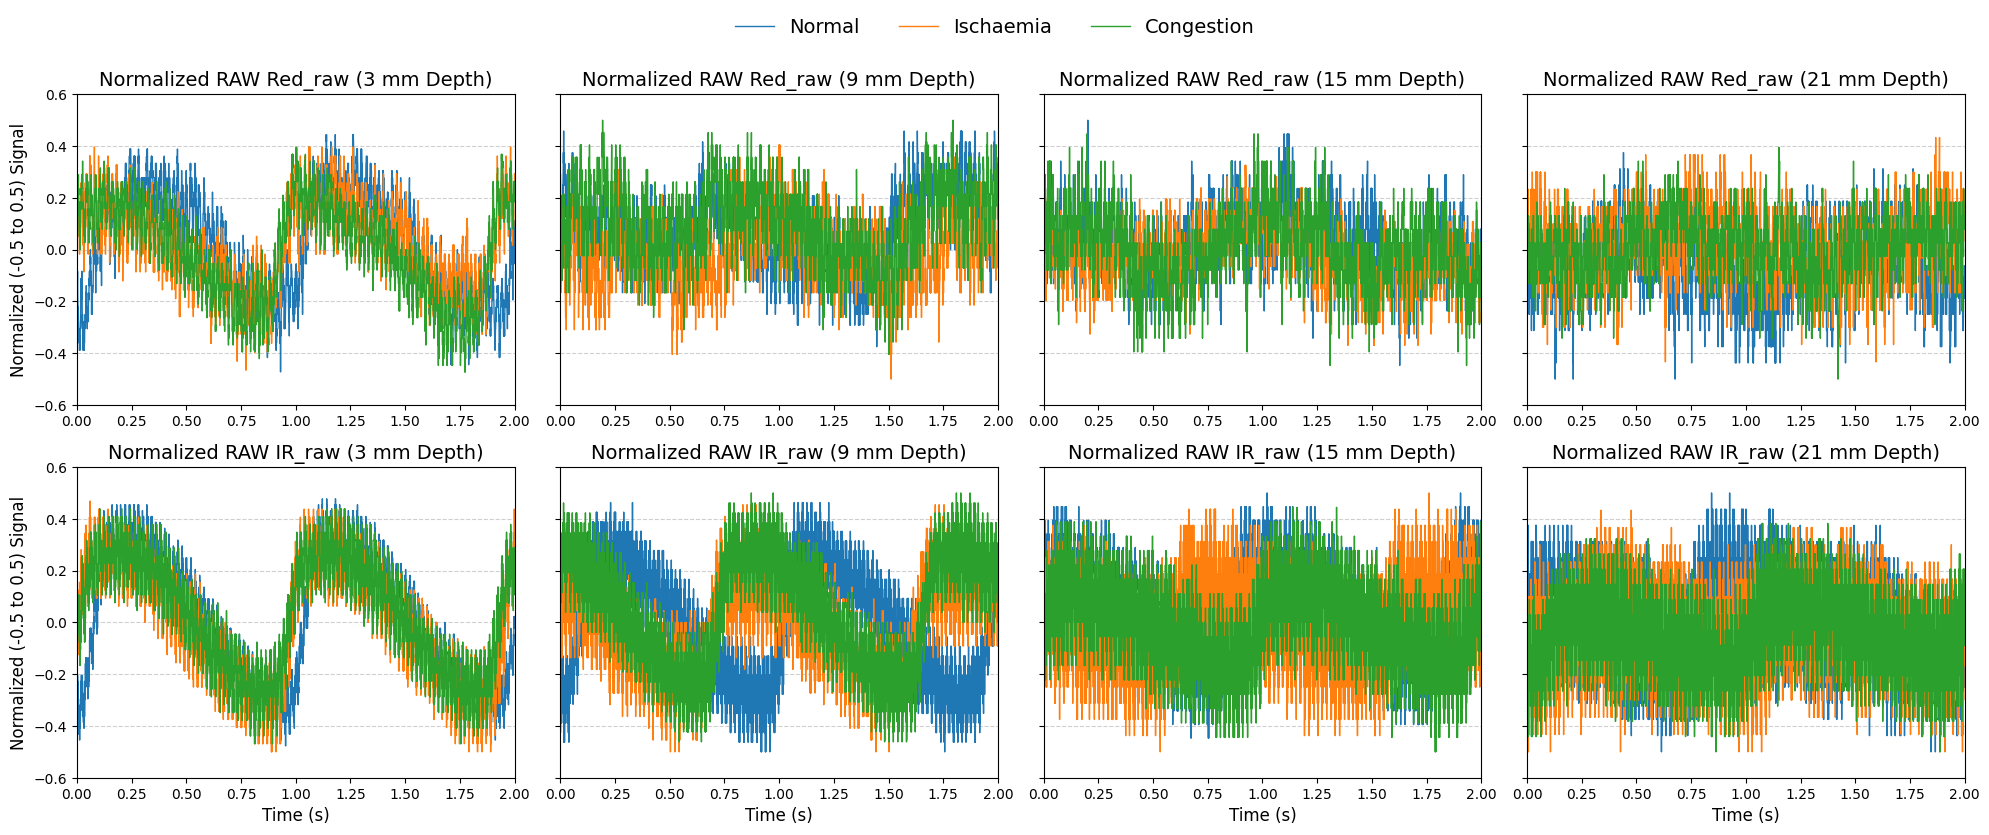

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 最終的に表示する時間 [秒]
search_window = 6     # 正規化・位置合わせに使用する時間 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"} # RAWデータを使用

# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)
plot_length = int(view_sec * fs) # 2s = 4000点


# ===== 正規化関数 (最小値-0.5, 最大値0.5に変換) =====
def normalize_to_range(data, min_val=-0.5, max_val=0.5):
    """
    データを指定された最小値と最大値の範囲に線形的に正規化する。
    """
    data_min = np.min(data)
    data_max = np.max(data)
    
    amplitude = data_max - data_min
    if amplitude < 1e-12:  
        # 振幅が極めて小さい場合、中央値で埋める
        return np.full_like(data, (min_val + max_val) / 2) 

    # 0-1 範囲にスケーリング
    normalized_0_1 = (data - data_min) / amplitude
    
    # 指定範囲 (-0.5から0.5) にスケーリング
    range_span = max_val - min_val
    normalized_data = normalized_0_1 * range_span + min_val
    
    return normalized_data

# ===== プロット実行 (RAWデータに直接正規化を適用) =====
fig, axes = plt.subplots(len(channels), len(depths), figsize=(20, 8), sharey=True)

for row_idx, (channel_key, channel_name) in enumerate(channels.items()):
    for col_idx, depth in enumerate(depths):
        
        ax = axes[row_idx, col_idx]
        
        for state_key, state_name in state_map.items():
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            
            try:
                df = pd.read_csv(file_name) 
                # 6s分のRAWデータをロード
                signal_6s = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
                
                # ★ 1. 6sデータ全体を正規化 ★
                normalized_signal_6s = normalize_to_range(signal_6s, min_val=-0.5, max_val=0.5)
                
                # ★ 2. ピーク（最大値）のインデックスを検出 ★
                # 正規化後のデータでピークを検出 (ノイズの影響を受けやすい点に注意)
                current_peak_idx = np.argmax(normalized_signal_6s)
                
                # ★ 3. ピークを開始位置（インデックス 0）に設定するためのシフト ★
                shift_amount = current_peak_idx
                shifted_normalized_signal_6s = np.roll(normalized_signal_6s, -shift_amount)
                
                # ★ 4. 最終表示データ: ピークから2秒後の位置から2秒分を切り出し ★
                plot_signal = shifted_normalized_signal_6s[plot_length : 2 * plot_length]
                
                # 時間軸の作成 (秒): 0から2秒
                time_axis = np.arange(len(plot_signal)) / fs
                ax.plot(time_axis, plot_signal, label=state_name, linewidth=1.0) # linewidthを細く設定
                
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                if state_key == "data1":
                     ax.text(0.5, 0.5, 'Data Missing', transform=ax.transAxes, ha='center', va='center', color='red', fontsize=12)


        # グラフの装飾
        ax.set_title(f"Normalized RAW {channel_name} ({depth} mm Depth)", fontsize=14)
        ax.set_xlim(0, view_sec)
        ax.set_ylim(-0.6, 0.6) # Y軸を固定 (-0.6 ~ 0.6)
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # 軸ラベルの設定 (外側のグラフのみ)
        if row_idx == len(channels) - 1:
            ax.set_xlabel("Time (s)", fontsize=12)
        if col_idx == 0:
            ax.set_ylabel(f"Normalized (-0.5 to 0.5) Signal", fontsize=12)

# 凡例の設定
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=14)

# 全体の調整
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [90]:
pip install tabulate

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [117]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product # グリッドサーチの組み合わせ生成用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20     # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
TARGET_DEPTH = 3      # 処理対象を3 mmに限定
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
# ノイズ BPF の Low-cut と High-cut を探索
# Low-cut: 10 Hz から 20 Hz まで 2 Hz 刻み (信号帯域のすぐ上からスタート)
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2)
# High-cut: 50 Hz から 200 Hz まで 50 Hz 刻み (広範囲のノイズをカバー)
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) 
# 例: 10/50, 10/100, 10/150, 10/200, 12/50, 12/100, ... の組み合わせを試す

# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             # 無効なカットオフ設定の場合は生データをコピーして返す
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        # このコードでは 'band' のみ使用
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と最適S/N比の計算 =====
# ----------------------------------------------------------------------
best_snr_results = {}
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

# チャンネルと状態をループ
for channel_key, channel_name in channels.items():
    for state_key, state_name in state_map.items():
        
        current_best_snr_db = -math.inf # 最小値で初期化
        best_cutoffs = (0, 0)
        
        # ファイルからRAWデータを読み込み
        depth = TARGET_DEPTH
        file_name = f"{depth}mm_adjusted_{state_key}.csv"
        
        try:
            df = pd.read_csv(file_name) 
            signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
            
            # 信号振幅 (RAW Pk-Pk) は固定
            signal_amplitude = calculate_amplitude(signal_raw)
            
            # --- グリッドサーチの実行 ---
            for lowcut, highcut in all_combinations:
                if lowcut >= highcut:
                    continue # 無効な組み合わせをスキップ
                
                # 1. ノイズ振幅 (Noise Amplitude) の計算
                noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                noise_amplitude = calculate_amplitude(noise_ac)
                
                # 2. S/N比の計算
                if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                    snr_ratio = signal_amplitude / noise_amplitude
                    snr_db = 20 * math.log10(snr_ratio)
                    
                    # 3. 最適解の更新
                    if snr_db > current_best_snr_db:
                        current_best_snr_db = snr_db
                        best_cutoffs = (lowcut, highcut)
                
        except FileNotFoundError:
            print(f"Error: File not found for {channel_name}, {state_name}")
            continue
        except KeyError:
            print(f"Error: Column not found in file for {channel_name}, {state_name}")
            continue
            
        # 結果を格納
        best_snr_results[(channel_name, state_name)] = {
            'SNR_dB': current_best_snr_db,
            'Lowcut': best_cutoffs[0],
            'Highcut': best_cutoffs[1],
            'SignalAmp': signal_amplitude if 'signal_amplitude' in locals() else 0 # 読み込みエラー対策
        }

# ----------------------------------------------------------------------
# ===== 結果の出力 =====
# ----------------------------------------------------------------------
output_data = []
for (channel, state), res in best_snr_results.items():
    output_data.append([
        TARGET_DEPTH,
        channel,
        state,
        f"{res['SignalAmp']:.3e}",
        f"{res['SNR_dB']:.2f}" if res['SNR_dB'] != -math.inf else "N/A",
        f"{res['Lowcut']} - {res['Highcut']} Hz"
    ])

print("="*90)
print(f"        Grid Search Results for Max S/N Ratio (Depth: {TARGET_DEPTH} mm, Order: {ORDER})")
print("="*90)
print(f"Search Space: Lowcut in {list(NOISE_LOWCUTS)}, Highcut in {list(NOISE_HIGHCUTS)}")
print("-" * 90)

headers = ['Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 'Max S/N Ratio (dB)', 'Optimal Noise BPF']
print(tabulate(output_data, headers=headers, tablefmt="fancy_grid"))

        Grid Search Results for Max S/N Ratio (Depth: 3 mm, Order: 6)
Search Space: Lowcut in [np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18), np.int64(20)], Highcut in [np.int64(50), np.int64(100), np.int64(150), np.int64(200)]
------------------------------------------------------------------------------------------
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            3 │ Red_raw   │ Normal     │                 0.007399 │                14.89 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Ischaemia  │                 0.005591 │                13.3

In [118]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product # グリッドサーチの組み合わせ生成用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20     # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
TARGET_DEPTH = 9      # 処理対象を3 mmに限定
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
# ノイズ BPF の Low-cut と High-cut を探索
# Low-cut: 10 Hz から 20 Hz まで 2 Hz 刻み (信号帯域のすぐ上からスタート)
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2)
# High-cut: 50 Hz から 200 Hz まで 50 Hz 刻み (広範囲のノイズをカバー)
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) 
# 例: 10/50, 10/100, 10/150, 10/200, 12/50, 12/100, ... の組み合わせを試す

# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             # 無効なカットオフ設定の場合は生データをコピーして返す
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        # このコードでは 'band' のみ使用
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と最適S/N比の計算 =====
# ----------------------------------------------------------------------
best_snr_results = {}
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

# チャンネルと状態をループ
for channel_key, channel_name in channels.items():
    for state_key, state_name in state_map.items():
        
        current_best_snr_db = -math.inf # 最小値で初期化
        best_cutoffs = (0, 0)
        
        # ファイルからRAWデータを読み込み
        depth = TARGET_DEPTH
        file_name = f"{depth}mm_adjusted_{state_key}.csv"
        
        try:
            df = pd.read_csv(file_name) 
            signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
            
            # 信号振幅 (RAW Pk-Pk) は固定
            signal_amplitude = calculate_amplitude(signal_raw)
            
            # --- グリッドサーチの実行 ---
            for lowcut, highcut in all_combinations:
                if lowcut >= highcut:
                    continue # 無効な組み合わせをスキップ
                
                # 1. ノイズ振幅 (Noise Amplitude) の計算
                noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                noise_amplitude = calculate_amplitude(noise_ac)
                
                # 2. S/N比の計算
                if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                    snr_ratio = signal_amplitude / noise_amplitude
                    snr_db = 20 * math.log10(snr_ratio)
                    
                    # 3. 最適解の更新
                    if snr_db > current_best_snr_db:
                        current_best_snr_db = snr_db
                        best_cutoffs = (lowcut, highcut)
                
        except FileNotFoundError:
            print(f"Error: File not found for {channel_name}, {state_name}")
            continue
        except KeyError:
            print(f"Error: Column not found in file for {channel_name}, {state_name}")
            continue
            
        # 結果を格納
        best_snr_results[(channel_name, state_name)] = {
            'SNR_dB': current_best_snr_db,
            'Lowcut': best_cutoffs[0],
            'Highcut': best_cutoffs[1],
            'SignalAmp': signal_amplitude if 'signal_amplitude' in locals() else 0 # 読み込みエラー対策
        }

# ----------------------------------------------------------------------
# ===== 結果の出力 =====
# ----------------------------------------------------------------------
output_data = []
for (channel, state), res in best_snr_results.items():
    output_data.append([
        TARGET_DEPTH,
        channel,
        state,
        f"{res['SignalAmp']:.3e}",
        f"{res['SNR_dB']:.2f}" if res['SNR_dB'] != -math.inf else "N/A",
        f"{res['Lowcut']} - {res['Highcut']} Hz"
    ])

print("="*90)
print(f"        Grid Search Results for Max S/N Ratio (Depth: {TARGET_DEPTH} mm, Order: {ORDER})")
print("="*90)
print(f"Search Space: Lowcut in {list(NOISE_LOWCUTS)}, Highcut in {list(NOISE_HIGHCUTS)}")
print("-" * 90)

headers = ['Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 'Max S/N Ratio (dB)', 'Optimal Noise BPF']
print(tabulate(output_data, headers=headers, tablefmt="fancy_grid"))

        Grid Search Results for Max S/N Ratio (Depth: 9 mm, Order: 6)
Search Space: Lowcut in [np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18), np.int64(20)], Highcut in [np.int64(50), np.int64(100), np.int64(150), np.int64(200)]
------------------------------------------------------------------------------------------
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            9 │ Red_raw   │ Normal     │                 0.004275 │                11.54 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            9 │ Red_raw   │ Ischaemia  │                 0.003617 │                11.3

In [119]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product # グリッドサーチの組み合わせ生成用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20     # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
TARGET_DEPTH = 15      # 処理対象を3 mmに限定
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
# ノイズ BPF の Low-cut と High-cut を探索
# Low-cut: 10 Hz から 20 Hz まで 2 Hz 刻み (信号帯域のすぐ上からスタート)
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2)
# High-cut: 50 Hz から 200 Hz まで 50 Hz 刻み (広範囲のノイズをカバー)
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) 
# 例: 10/50, 10/100, 10/150, 10/200, 12/50, 12/100, ... の組み合わせを試す

# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             # 無効なカットオフ設定の場合は生データをコピーして返す
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        # このコードでは 'band' のみ使用
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と最適S/N比の計算 =====
# ----------------------------------------------------------------------
best_snr_results = {}
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

# チャンネルと状態をループ
for channel_key, channel_name in channels.items():
    for state_key, state_name in state_map.items():
        
        current_best_snr_db = -math.inf # 最小値で初期化
        best_cutoffs = (0, 0)
        
        # ファイルからRAWデータを読み込み
        depth = TARGET_DEPTH
        file_name = f"{depth}mm_adjusted_{state_key}.csv"
        
        try:
            df = pd.read_csv(file_name) 
            signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
            
            # 信号振幅 (RAW Pk-Pk) は固定
            signal_amplitude = calculate_amplitude(signal_raw)
            
            # --- グリッドサーチの実行 ---
            for lowcut, highcut in all_combinations:
                if lowcut >= highcut:
                    continue # 無効な組み合わせをスキップ
                
                # 1. ノイズ振幅 (Noise Amplitude) の計算
                noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                noise_amplitude = calculate_amplitude(noise_ac)
                
                # 2. S/N比の計算
                if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                    snr_ratio = signal_amplitude / noise_amplitude
                    snr_db = 20 * math.log10(snr_ratio)
                    
                    # 3. 最適解の更新
                    if snr_db > current_best_snr_db:
                        current_best_snr_db = snr_db
                        best_cutoffs = (lowcut, highcut)
                
        except FileNotFoundError:
            print(f"Error: File not found for {channel_name}, {state_name}")
            continue
        except KeyError:
            print(f"Error: Column not found in file for {channel_name}, {state_name}")
            continue
            
        # 結果を格納
        best_snr_results[(channel_name, state_name)] = {
            'SNR_dB': current_best_snr_db,
            'Lowcut': best_cutoffs[0],
            'Highcut': best_cutoffs[1],
            'SignalAmp': signal_amplitude if 'signal_amplitude' in locals() else 0 # 読み込みエラー対策
        }

# ----------------------------------------------------------------------
# ===== 結果の出力 =====
# ----------------------------------------------------------------------
output_data = []
for (channel, state), res in best_snr_results.items():
    output_data.append([
        TARGET_DEPTH,
        channel,
        state,
        f"{res['SignalAmp']:.3e}",
        f"{res['SNR_dB']:.2f}" if res['SNR_dB'] != -math.inf else "N/A",
        f"{res['Lowcut']} - {res['Highcut']} Hz"
    ])

print("="*90)
print(f"        Grid Search Results for Max S/N Ratio (Depth: {TARGET_DEPTH} mm, Order: {ORDER})")
print("="*90)
print(f"Search Space: Lowcut in {list(NOISE_LOWCUTS)}, Highcut in {list(NOISE_HIGHCUTS)}")
print("-" * 90)

headers = ['Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 'Max S/N Ratio (dB)', 'Optimal Noise BPF']
print(tabulate(output_data, headers=headers, tablefmt="fancy_grid"))

        Grid Search Results for Max S/N Ratio (Depth: 15 mm, Order: 6)
Search Space: Lowcut in [np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18), np.int64(20)], Highcut in [np.int64(50), np.int64(100), np.int64(150), np.int64(200)]
------------------------------------------------------------------------------------------
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│           15 │ Red_raw   │ Normal     │                 0.003782 │                12.15 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│           15 │ Red_raw   │ Ischaemia  │                 0.003782 │                11.

In [120]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product # グリッドサーチの組み合わせ生成用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20     # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
TARGET_DEPTH = 21      # 処理対象を3 mmに限定
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
# ノイズ BPF の Low-cut と High-cut を探索
# Low-cut: 10 Hz から 20 Hz まで 2 Hz 刻み (信号帯域のすぐ上からスタート)
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2)
# High-cut: 50 Hz から 200 Hz まで 50 Hz 刻み (広範囲のノイズをカバー)
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) 
# 例: 10/50, 10/100, 10/150, 10/200, 12/50, 12/100, ... の組み合わせを試す

# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             # 無効なカットオフ設定の場合は生データをコピーして返す
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        # このコードでは 'band' のみ使用
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と最適S/N比の計算 =====
# ----------------------------------------------------------------------
best_snr_results = {}
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

# チャンネルと状態をループ
for channel_key, channel_name in channels.items():
    for state_key, state_name in state_map.items():
        
        current_best_snr_db = -math.inf # 最小値で初期化
        best_cutoffs = (0, 0)
        
        # ファイルからRAWデータを読み込み
        depth = TARGET_DEPTH
        file_name = f"{depth}mm_adjusted_{state_key}.csv"
        
        try:
            df = pd.read_csv(file_name) 
            signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
            
            # 信号振幅 (RAW Pk-Pk) は固定
            signal_amplitude = calculate_amplitude(signal_raw)
            
            # --- グリッドサーチの実行 ---
            for lowcut, highcut in all_combinations:
                if lowcut >= highcut:
                    continue # 無効な組み合わせをスキップ
                
                # 1. ノイズ振幅 (Noise Amplitude) の計算
                noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                noise_amplitude = calculate_amplitude(noise_ac)
                
                # 2. S/N比の計算
                if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                    snr_ratio = signal_amplitude / noise_amplitude
                    snr_db = 20 * math.log10(snr_ratio)
                    
                    # 3. 最適解の更新
                    if snr_db > current_best_snr_db:
                        current_best_snr_db = snr_db
                        best_cutoffs = (lowcut, highcut)
                
        except FileNotFoundError:
            print(f"Error: File not found for {channel_name}, {state_name}")
            continue
        except KeyError:
            print(f"Error: Column not found in file for {channel_name}, {state_name}")
            continue
            
        # 結果を格納
        best_snr_results[(channel_name, state_name)] = {
            'SNR_dB': current_best_snr_db,
            'Lowcut': best_cutoffs[0],
            'Highcut': best_cutoffs[1],
            'SignalAmp': signal_amplitude if 'signal_amplitude' in locals() else 0 # 読み込みエラー対策
        }

# ----------------------------------------------------------------------
# ===== 結果の出力 =====
# ----------------------------------------------------------------------
output_data = []
for (channel, state), res in best_snr_results.items():
    output_data.append([
        TARGET_DEPTH,
        channel,
        state,
        f"{res['SignalAmp']:.3e}",
        f"{res['SNR_dB']:.2f}" if res['SNR_dB'] != -math.inf else "N/A",
        f"{res['Lowcut']} - {res['Highcut']} Hz"
    ])

print("="*90)
print(f"        Grid Search Results for Max S/N Ratio (Depth: {TARGET_DEPTH} mm, Order: {ORDER})")
print("="*90)
print(f"Search Space: Lowcut in {list(NOISE_LOWCUTS)}, Highcut in {list(NOISE_HIGHCUTS)}")
print("-" * 90)

headers = ['Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 'Max S/N Ratio (dB)', 'Optimal Noise BPF']
print(tabulate(output_data, headers=headers, tablefmt="fancy_grid"))

        Grid Search Results for Max S/N Ratio (Depth: 21 mm, Order: 6)
Search Space: Lowcut in [np.int64(10), np.int64(12), np.int64(14), np.int64(16), np.int64(18), np.int64(20)], Highcut in [np.int64(50), np.int64(100), np.int64(150), np.int64(200)]
------------------------------------------------------------------------------------------
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│           21 │ Red_raw   │ Normal     │                 0.003453 │                11.82 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│           21 │ Red_raw   │ Ischaemia  │                 0.003289 │                12.

In [122]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product 
import io # CSV出力の補助用

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20    # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
depths_to_process = [3, 9, 15, 21] # ★処理対象の深さリスト★
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間 ★★★ =====
NOISE_LOWCUTS = np.arange(10, 20 + 2, 2) # 10, 12, ..., 20 Hz
NOISE_HIGHCUTS = np.arange(50, 200 + 50, 50) # 50, 100, 150, 200 Hz


# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と結果の統合 =====
# ----------------------------------------------------------------------
final_results_list = []
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

for depth in depths_to_process:
    for channel_key, channel_name in channels.items():
        for state_key, state_name in state_map.items():
            
            current_best_snr_db = -math.inf 
            best_cutoffs = (0, 0)
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            signal_amplitude = 0
            
            try:
                # RAWデータを読み込み (float64を強制)
                df = pd.read_csv(file_name) 
                signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
                
                # 信号振幅 (RAW Pk-Pk) は固定
                signal_amplitude = calculate_amplitude(signal_raw)
                
                # --- グリッドサーチの実行 ---
                for lowcut, highcut in all_combinations:
                    if lowcut >= highcut:
                        continue 
                    
                    # 1. ノイズ振幅 (Noise Amplitude) の計算
                    noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                    noise_amplitude = calculate_amplitude(noise_ac)
                    
                    # 2. S/N比の計算
                    if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                        snr_ratio = signal_amplitude / noise_amplitude
                        snr_db = 20 * math.log10(snr_ratio)
                        
                        # 3. 最適解の更新
                        if snr_db > current_best_snr_db:
                            current_best_snr_db = snr_db
                            best_cutoffs = (lowcut, highcut)
                    
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                continue
            except KeyError:
                print(f"Warning: Column '{channel_key}' not found in file: {file_name}")
                continue
            
            # 結果をリストに追加 (指数表記なし)
            if current_best_snr_db != -math.inf:
                # 指数表記を避けるために通常の浮動小数点形式に変換
                final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}", # 信号振幅 (10桁精度)
                    f"{current_best_snr_db:.2f}",
                    f"{best_cutoffs[0]} - {best_cutoffs[1]} Hz"
                ])
            else:
                 final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}",
                    "N/A",
                    "N/A"
                ])


# ----------------------------------------------------------------------
# ===== CSVファイルへの保存 =====
# ----------------------------------------------------------------------
output_df = pd.DataFrame(final_results_list, columns=[
    'Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 
    'Max S/N Ratio (dB)', 'Optimal Noise BPF'
])

output_file = 'ppg_snr_grid_search_results.csv'
# to_csvで指数表記を防ぐための設定（float_formatを使用）
output_df.to_csv(output_file, index=False, float_format='%.10f')

print("="*80)
print(f"✅ 全深さのグリッドサーチが完了しました。")
print(f"✅ 結果は {output_file} に保存されました (指数表記なし)。")
print("="*80)
# コンソールにも表形式で一部表示
print("\n--- サマリー結果 (CSVに保存されたデータ) ---")
print(tabulate(output_df.head(12), headers='keys', tablefmt='fancy_grid', showindex=False))

✅ 全深さのグリッドサーチが完了しました。
✅ 結果は ppg_snr_grid_search_results.csv に保存されました (指数表記なし)。

--- サマリー結果 (CSVに保存されたデータ) ---
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            3 │ Red_raw   │ Normal     │               0.0073994  │                14.89 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Ischaemia  │               0.00559066 │                13.34 │ 18 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_raw   │ Congestion │               0.009537   │                17.79 │ 

In [127]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import math
from tabulate import tabulate 
from itertools import product 

# ===== パラメータ（ユーザー設定） =====
fs = 2000             # サンプリング周波数 [Hz]
search_window = 20    # S/N比計算に使用するデータ長 [秒]
start_search = 3      # 検索ウィンドウの開始時間 [秒]
depths_to_process = [3, 9, 15, 21] # 処理対象の深さリスト
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red_raw", "ppgA_IR_raw":"IR_raw"}

# ===== フィルター設定 (共通) =====
ORDER = 6             # フィルター次数
PADLEN = 500          # 端点処理のパディング長

# ===== ★★★ グリッドサーチ探索空間（修正） ★★★ =====
NOISE_LOWCUTS = np.arange(10, 20 + 1, 1) # 10, 12, ..., 20 Hz
# ★修正: 40 Hz から 150 Hz まで 10 Hz 刻み★
NOISE_HIGHCUTS = np.arange(50, 150 + 50, 50) 


# データの読み込み範囲をインデックスに変換
load_start_index = int(start_search * fs)
load_end_index = int((start_search + search_window) * fs)


# ===== フィルタリング関数 (変更なし) =====
def butter_filter(data, cutoff, fs, btype, order=6, padlen=500):
    """汎用バターワースフィルター（端点処理付き）"""
    nyquist = 0.5 * fs
    
    if btype == 'band':
        low = cutoff[0] / nyquist
        high = cutoff[1] / nyquist
        if low >= high or low >= 1.0 or high >= 1.0:
             return data.copy()
        
        b, a = butter(order, [low, high], btype='band', analog=False)
    else:
        return data.copy() 
        
    first_value = data[0]
    last_value = data[-1]
    padded_data = np.pad(data, (padlen, padlen), 'constant', constant_values=(first_value, last_value))

    y_padded = filtfilt(b, a, padded_data)
    y = y_padded[padlen:padlen + len(data)]

    return y

def calculate_amplitude(signal):
    """信号のPeak-to-Peak振幅を計算"""
    return np.max(signal) - np.min(signal)

# ----------------------------------------------------------------------
# ===== グリッドサーチ実行と結果の統合 =====
# ----------------------------------------------------------------------
final_results_list = []
all_combinations = list(product(NOISE_LOWCUTS, NOISE_HIGHCUTS))

for depth in depths_to_process:
    for channel_key, channel_name in channels.items():
        for state_key, state_name in state_map.items():
            
            current_best_snr_db = -math.inf 
            best_cutoffs = (0, 0)
            
            file_name = f"{depth}mm_adjusted_{state_key}.csv"
            signal_amplitude = 0
            
            try:
                # RAWデータを読み込み (float64を強制)
                df = pd.read_csv(file_name) 
                signal_raw = df[channel_key].values[load_start_index:load_end_index].astype(np.float64)
                
                # 信号振幅 (RAW Pk-Pk) は固定
                signal_amplitude = calculate_amplitude(signal_raw)
                
                # --- グリッドサーチの実行 ---
                for lowcut, highcut in all_combinations:
                    if lowcut >= highcut:
                        continue 
                    
                    # 1. ノイズ振幅 (Noise Amplitude) の計算
                    noise_ac = butter_filter(signal_raw, [lowcut, highcut], fs, 'band', ORDER, PADLEN)
                    noise_amplitude = calculate_amplitude(noise_ac)
                    
                    # 2. S/N比の計算
                    if signal_amplitude > 1e-12 and noise_amplitude > 1e-12:
                        snr_ratio = signal_amplitude / noise_amplitude
                        snr_db = 20 * math.log10(snr_ratio)
                        
                        # 3. 最適解の更新
                        if snr_db > current_best_snr_db:
                            current_best_snr_db = snr_db
                            best_cutoffs = (lowcut, highcut)
                    
            except FileNotFoundError:
                print(f"Warning: File not found: {file_name}")
                continue
            except KeyError:
                print(f"Warning: Column '{channel_key}' not found in file: {file_name}")
                continue
            
            # 結果をリストに追加 (指数表記なし)
            if current_best_snr_db != -math.inf:
                # 指数表記を避けるために通常の浮動小数点形式に変換
                final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}", # 信号振幅 (10桁精度)
                    f"{current_best_snr_db:.2f}",
                    f"{best_cutoffs[0]} - {best_cutoffs[1]} Hz"
                ])
            else:
                 final_results_list.append([
                    depth,
                    channel_name,
                    state_name,
                    f"{signal_amplitude:.10f}",
                    "N/A",
                    "N/A"
                ])


# ----------------------------------------------------------------------
# ===== 結果のコンソール出力 =====
# ----------------------------------------------------------------------
output_df = pd.DataFrame(final_results_list, columns=[
    'Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 
    'Max S/N Ratio (dB)', 'Optimal Noise BPF'
])

print("="*90)
print(f"        Grid Search Results for Max S/N Ratio (All Depths, Order: {ORDER})")
print("="*90)
print(f"Noise Lowcut Search: {list(NOISE_LOWCUTS)} Hz")
print(f"Noise Highcut Search: {list(NOISE_HIGHCUTS)} Hz")
print("-" * 90)

headers = ['Depth (mm)', 'Channel', 'State', 'Signal Amp (RAW Pk-Pk)', 'Max S/N Ratio (dB)', 'Optimal Noise BPF']
print(tabulate(output_df, headers=headers, tablefmt='fancy_grid', showindex=False))

        Grid Search Results for Max S/N Ratio (All Depths, Order: 6)
Noise Lowcut Search: [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)] Hz
Noise Highcut Search: [np.int64(50), np.int64(100), np.int64(150)] Hz
------------------------------------------------------------------------------------------
╒══════════════╤═══════════╤════════════╤══════════════════════════╤══════════════════════╤═════════════════════╕
│   Depth (mm) │ Channel   │ State      │   Signal Amp (RAW Pk-Pk) │   Max S/N Ratio (dB) │ Optimal Noise BPF   │
╞══════════════╪═══════════╪════════════╪══════════════════════════╪══════════════════════╪═════════════════════╡
│            3 │ Red_raw   │ Normal     │               0.0073994  │                14.89 │ 20 - 50 Hz          │
├──────────────┼───────────┼────────────┼──────────────────────────┼──────────────────────┼─────────────────────┤
│            3 │ Red_